In [17]:
# Mount Google Drive to access your dataset
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install nltk
!pip install vaderSentiment

# Import libraries
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# Load dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/Web Mining Sem 3/Final proj/may_july_chunk_1.csv'
df = pd.read_csv(file_path)

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

print("\nSample Rows:")
print(df.head(5))

print(df.columns)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         50000 non-null  int64  
 1   text                       50000 non-null  object 
 2   url                        50000 non-null  object 
 3   epoch                      50000 non-null  int64  
 4   media                      50000 non-null  object 
 5   retweetedTweet             50000 non-null  bool   
 6   retweetedTweetID           0 non-null      float64
 7   retweetedUserID            0 non-null      float64
 8   id_str                     50000 non-null  int64  
 9   lang                       50000 non-null  object 
 10  rawContent                 50000 non-null  object 
 11  replyCount                 50000 non-null  int64  
 12  retweetCount               50000 non-null  int64  
 13  likeCount                  50000

In [19]:
#all columns in the dataset

print(df.columns)

Index(['id', 'text', 'url', 'epoch', 'media', 'retweetedTweet',
       'retweetedTweetID', 'retweetedUserID', 'id_str', 'lang', 'rawContent',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'conversationIdStr', 'hashtags', 'mentionedUsers',
       'links', 'viewCount', 'quotedTweet', 'in_reply_to_screen_name',
       'in_reply_to_status_id_str', 'in_reply_to_user_id_str', 'location',
       'cash_app_handle', 'user', 'date', '_type'],
      dtype='object')


In [20]:
# Drop irrelevant columns
columns_to_drop = ['retweetedTweetID', 'retweetedUserID', 'location', 'cash_app_handle', 'date', '_type']
df = df.drop(columns=columns_to_drop)

# Filter only English tweets
df = df[df['lang'] == 'en']

# Download necessary NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [21]:
#cleaning the data

# Define text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters
    text = text.lower()  # Convert to lowercase

    # Download necessary NLTK resources if not already downloaded
    import nltk
    nltk.download('punkt_tab', quiet=True) # Download punkt_tab resource

    tokens = word_tokenize(text)  # Tokenize text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return " ".join(tokens)

# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

print("\nCleaned Text Sample:")
print(df[['text', 'cleaned_text']].head())


Cleaned Text Sample:
                                                text  \
0  @lukepbeasley I cant imagine anyone actually f...   
1  Voters can also sway me away from voting  for ...   
2  @PoodleHead57 @BobOnderMO Can you name that am...   
3  @Morning_Joe @JoeNBC The fact remains that Joe...   
4  @BidenHQ That's funny you're obviously trying ...   

                                        cleaned_text  
0  cant imagine anyone actually feels way much ha...  
1  voters also sway away voting someone way see p...  
2  name amount charges brought anybody history ri...  
3         fact remains joe biden simply terrible man  
4  thats funny youre obviously trying coverup bid...  


In [23]:
#sentiment analysis starts

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Calculate sentiment scores
df['sentiment_score'] = df['cleaned_text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Classify sentiment into positive, neutral, or negative
def classify_sentiment(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['sentiment_score'].apply(classify_sentiment)

print("\nSentiment Analysis Results:")
print(df[['cleaned_text', 'sentiment_score', 'sentiment_label']].head())



Sentiment Analysis Results:
                                        cleaned_text  sentiment_score  \
0  cant imagine anyone actually feels way much ha...          -0.2263   
1  voters also sway away voting someone way see p...          -0.3182   
2  name amount charges brought anybody history ri...          -0.1082   
3         fact remains joe biden simply terrible man          -0.4767   
4  thats funny youre obviously trying coverup bid...           0.4404   

  sentiment_label  
0        negative  
1        negative  
2        negative  
3        negative  
4        positive  


<ipython-input-24-5ae656e95cdd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=df, palette='viridis')


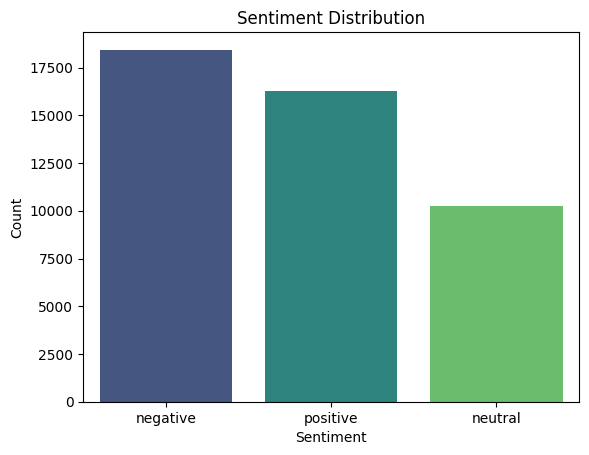

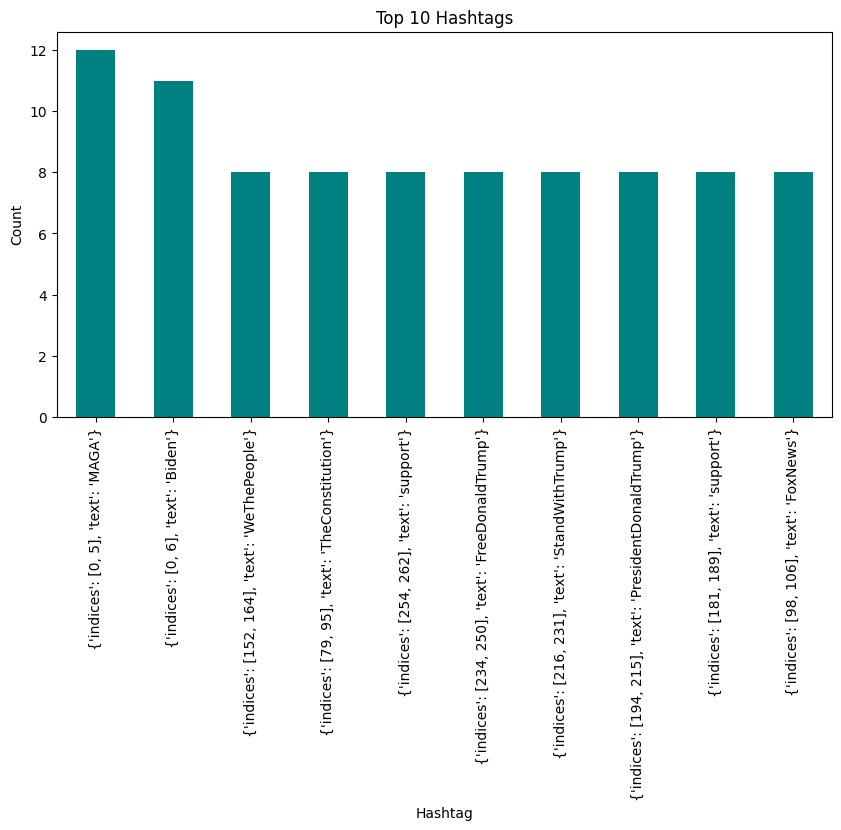

In [24]:
#step 5 - Exploratory data analysis EDA

# Sentiment distribution
sns.countplot(x='sentiment_label', data=df, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Extract hashtags from tweets
import ast
df['hashtags_list'] = df['hashtags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
all_hashtags = [hashtag for hashtags in df['hashtags_list'] for hashtag in hashtags]
top_hashtags = pd.Series(all_hashtags).value_counts().head(10)

# Plot top hashtags
top_hashtags.plot(kind='bar', title='Top 10 Hashtags', figsize=(10, 5), color='teal')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.show()


In [25]:
#step 6 - saving cleaned data

# Save cleaned dataset to Google Drive
output_path = '/content/drive/MyDrive/Colab Notebooks/Web Mining Sem 3/Final proj/cleaned data 1.csv'  # Replace with your directory
df.to_csv(output_path, index=False)
print(f"Processed dataset saved to: {output_path}")


Processed dataset saved to: /content/drive/MyDrive/Colab Notebooks/Web Mining Sem 3/Final proj/cleaned data 1.csv


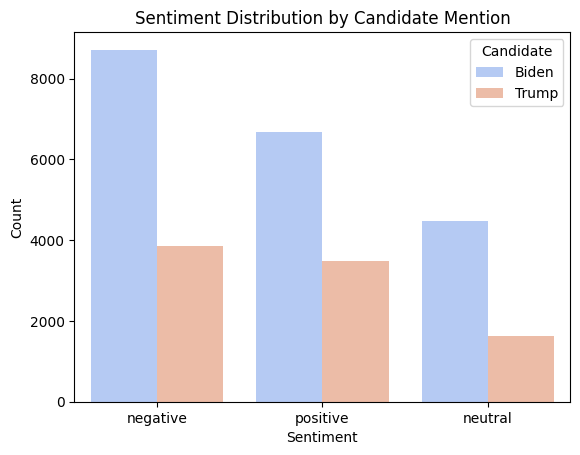

In [26]:
#step 7 - candidate specific analysis
#Analyze sentiments for specific candidates like "Trump" or "Biden."


# Filter tweets mentioning specific candidates
candidate_tweets = df[df['cleaned_text'].str.contains('trump|biden', case=False, na=False)]

# Sentiment distribution for each candidate
sns.countplot(x='sentiment_label', data=candidate_tweets, hue=candidate_tweets['cleaned_text'].str.contains('trump', case=False, na=False), palette='coolwarm')
plt.title('Sentiment Distribution by Candidate Mention')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(['Biden', 'Trump'], title='Candidate')
plt.show()


In [ ]:
#8. Reporting and Visualization
# Summarize key insights:

# Sentiment distribution.
# Engagement by sentiment.
# Top hashtags and their associated sentiments.

Average Engagement Metrics by Sentiment:
                 likeCount  retweetCount  replyCount
sentiment_label                                     
negative         19.842745      5.236290    2.311310
neutral          14.745300      2.223045    1.421155
positive         23.876458      4.875537    2.930404


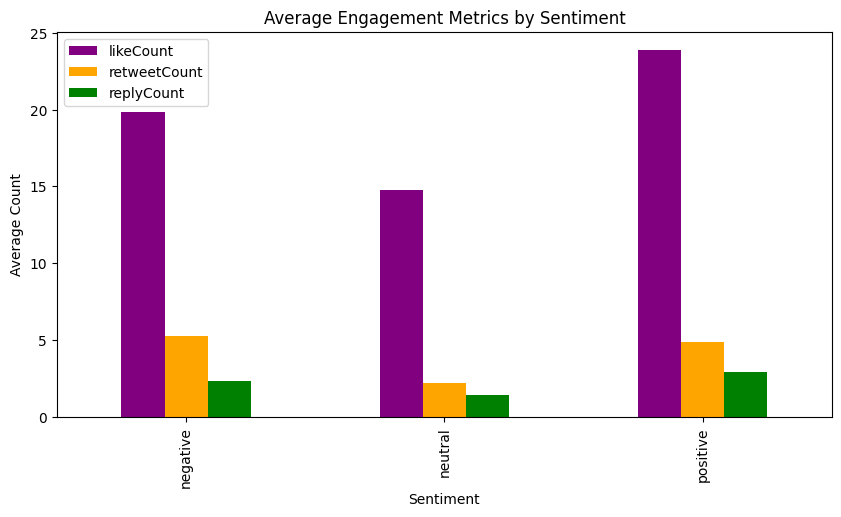

In [27]:
# Engagement metrics by sentiment
engagement_metrics = df.groupby('sentiment_label')[['likeCount', 'retweetCount', 'replyCount']].mean()
print("Average Engagement Metrics by Sentiment:")
print(engagement_metrics)

# Visualize average engagement
engagement_metrics.plot(kind='bar', figsize=(10, 5), color=['purple', 'orange', 'green'])
plt.title('Average Engagement Metrics by Sentiment')
plt.ylabel('Average Count')
plt.xlabel('Sentiment')
plt.show()


In [28]:
# Summary
# This project includes:

# Data Cleaning: Preprocessing tweet text and removing irrelevant columns.
# Sentiment Analysis: Using VADER for sentiment scoring and classification.
# Exploratory Analysis: Analyzing sentiment trends, hashtags, and engagement metrics.
# Candidate Mentions: Filtering tweets for specific candidates.
# Visualization: Creating bar charts and distributions for insights.

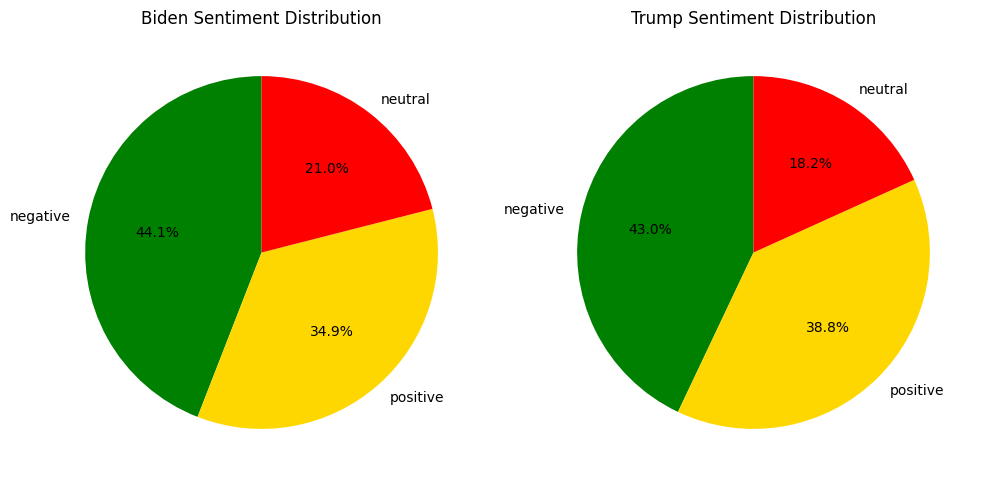

In [29]:
#pie chart for biden vs trump
import matplotlib.pyplot as plt

# Filter tweets mentioning "Biden" and "Trump"
biden_tweets = df[df['cleaned_text'].str.contains('biden', case=False, na=False)]
trump_tweets = df[df['cleaned_text'].str.contains('trump', case=False, na=False)]

# Count sentiment labels for each candidate
biden_sentiment_counts = biden_tweets['sentiment_label'].value_counts()
trump_sentiment_counts = trump_tweets['sentiment_label'].value_counts()

# Create pie chart for Biden
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
biden_sentiment_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['green', 'gold', 'red'])
plt.title("Biden Sentiment Distribution")
plt.ylabel('')  # Remove the default ylabel

# Create pie chart for Trump
plt.subplot(1, 2, 2)
trump_sentiment_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=['green', 'gold', 'red'])
plt.title("Trump Sentiment Distribution")
plt.ylabel('')  # Remove the default ylabel

plt.tight_layout()
plt.show()


In [30]:
#predicting who is gonna win
#1. Analyze Sentiment and Engagement
import matplotlib.pyplot as plt
import seaborn as sns

# Filter tweets mentioning "Biden" and "Trump"
biden_tweets = df[df['cleaned_text'].str.contains('biden', case=False, na=False)]
trump_tweets = df[df['cleaned_text'].str.contains('trump', case=False, na=False)]

# Calculate sentiment distribution for both candidates
biden_sentiment_counts = biden_tweets['sentiment_label'].value_counts(normalize=True) * 100
trump_sentiment_counts = trump_tweets['sentiment_label'].value_counts(normalize=True) * 100

# Calculate average engagement metrics for both candidates
biden_engagement = biden_tweets[['likeCount', 'retweetCount', 'replyCount']].mean()
trump_engagement = trump_tweets[['likeCount', 'retweetCount', 'replyCount']].mean()


<ipython-input-31-282b6ae03c1c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=candidates, y=positive_sentiments, palette=['blue', 'red'])


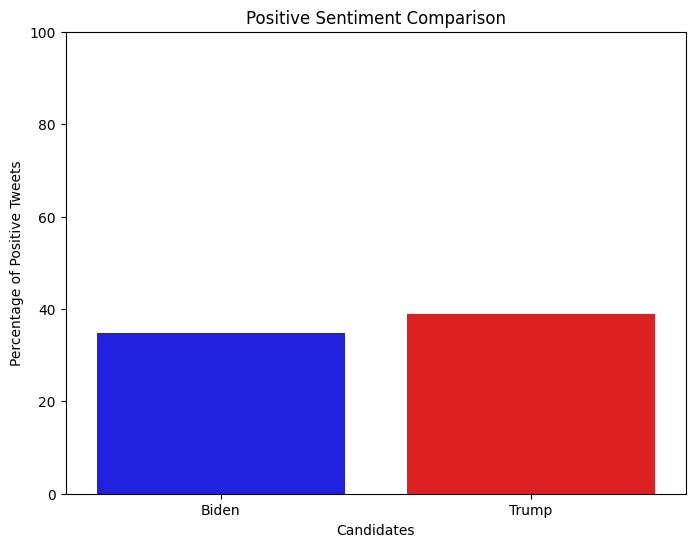

In [31]:
#2. Visualize Positive Sentiment Comparison
# Compare positive sentiment percentages
positive_sentiments = [biden_sentiment_counts.get('positive', 0), trump_sentiment_counts.get('positive', 0)]
candidates = ['Biden', 'Trump']

plt.figure(figsize=(8, 6))
sns.barplot(x=candidates, y=positive_sentiments, palette=['blue', 'red'])
plt.title('Positive Sentiment Comparison')
plt.ylabel('Percentage of Positive Tweets')
plt.xlabel('Candidates')
plt.ylim(0, 100)
plt.show()


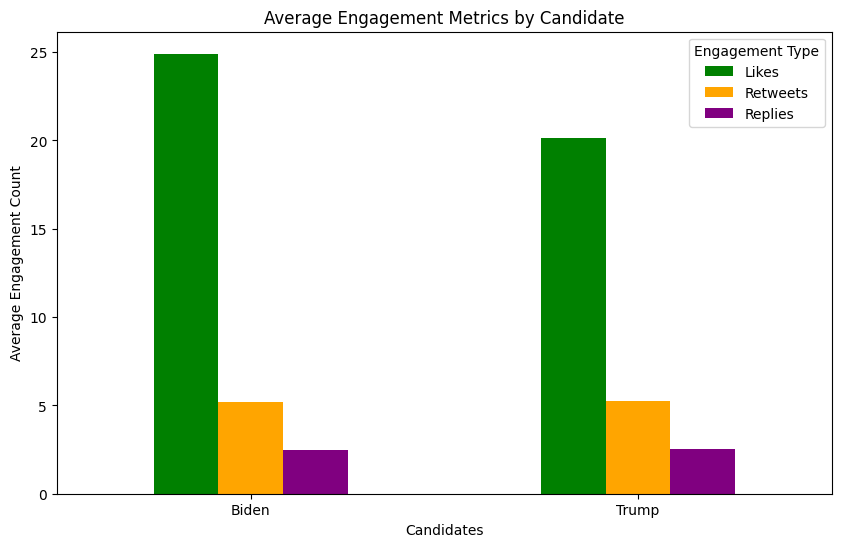

In [32]:
#3. Visualize Engagement Metrics

# Combine engagement metrics into a DataFrame
engagement_data = pd.DataFrame({
    'Candidate': ['Biden', 'Trump'],
    'Likes': [biden_engagement['likeCount'], trump_engagement['likeCount']],
    'Retweets': [biden_engagement['retweetCount'], trump_engagement['retweetCount']],
    'Replies': [biden_engagement['replyCount'], trump_engagement['replyCount']]
}).set_index('Candidate')

# Plot engagement metrics
engagement_data.plot(kind='bar', figsize=(10, 6), color=['green', 'orange', 'purple'])
plt.title('Average Engagement Metrics by Candidate')
plt.ylabel('Average Engagement Count')
plt.xlabel('Candidates')
plt.xticks(rotation=0)
plt.legend(title='Engagement Type')
plt.show()
